In [1]:
import myosuite
import hydra
import gym
import os
import json
import time as timer
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import VecNormalize
import numpy as np
import torch
import myosuite.envs.myo.myobase
import h5py
from tqdm import tqdm
from torch.utils.data.sampler import BatchSampler, SequentialSampler, SubsetRandomSampler

from pathlib import Path
import yaml

from mujoco import mjtVisFlag

import imageio
from gym import spaces
import matplotlib.pyplot as plt
import robomimic.utils.tensor_utils as TensorUtils

MyoSuite:> Registering Myo Envs


In [2]:
multi_path = "2024-05-16/21-37-31" 
model_ckpt_path = Path(f"/home/krishnans/myosuite/myosuite/agents/multirun/{multi_path}")

print(model_ckpt_path.exists())
model_ckpt_roots = list(filter(lambda x: not x.name.startswith('.') and x.is_dir(), model_ckpt_path.iterdir()))
filter_envs = ['handreach', 'pentwirl', 'objhold', 'keyturn', 'handpose']
all_envs = [(ckpt_dir, yaml.safe_load((ckpt_dir / "job_config.json").open())['env']) for ckpt_dir in model_ckpt_roots]
envs = list(filter(lambda x: any([y in x[1].lower() for y in filter_envs]) and any([str(x).endswith('.zip') for x in x[0].iterdir()]), all_envs))
envs



True


[(PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/6'),
  'myoHandPenTwirlRandom-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/2'),
  'myoHandObjHoldFixed-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/1'),
  'myoHandKeyTurnRandom-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/8'),
  'myoHandKeyTurnFixed-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/0'),
  'myoHandPoseFixed-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/7'),
  'myoHandPenTwirlFixed-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/4'),
  'myoHandPoseRandom-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2024-05-16/21-37-31/9'),
  'myoHandObjHoldRandom-v0'),
 (PosixPath('/home/krishnans/myosuite/myosuite/agents/multirun/2

In [152]:
','.join([env[1] for env in envs])

'myoHandPoseFixed-v0,myoHandKeyTurnRandom-v0,myoHandObjHoldFixed-v0,myoHandReachFixed-v0,myoHandPoseRandom-v0,myoHandReachRandom-v0,myoHandPenTwirlRandom-v0,myoHandPenTwirlFixed-v0,myoHandKeyTurnFixed-v0,myoHandObjHoldRandom-v0'

## Simple create env and run policy example
```python
num_rollouts = 500

eval_env = make_vec_env(cfg.env, n_envs=cfg.n_eval_env)
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)

model = PPO(cfg.policy, eval_env,  verbose=1,
                    learning_rate=cfg.learning_rate, 
                    batch_size=cfg.batch_size, 
                    gamma=cfg.gamma, **cfg.alg_hyper_params)
model = PPO.load(model_ckpt_dir + "/" + cfg.env + "_PPO_model")

obs = eval_env.reset()
dones = np.zeros(1)
it = 0
while True:
    with torch.no_grad():
        it += 1
        action, _states = model.predict(obs)
        obs, rewards, dones, info = eval_env.step(action)
        if any(dones):
            break
print (it)
```

In [8]:
class RolloutStorage:

    def __init__(
        self,
        num_envs,
        num_transitions_per_env,
        obs_shape,
        states_shape,
        actions_shape,
        device="cpu",
        sampler="sequential",
    ):

        self.device = device
        self.sampler = sampler

        # Core
        self.observations = torch.zeros(num_transitions_per_env, num_envs, *obs_shape, device=self.device)
        self.states = torch.zeros(num_transitions_per_env, num_envs, *states_shape, device=self.device)
        self.rewards = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.actions = torch.zeros(num_transitions_per_env, num_envs, *actions_shape, device=self.device)
        self.dones = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device).byte()

        # For PPO
        self.actions_log_prob = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.values = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.returns = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.advantages = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.mu = torch.zeros(num_transitions_per_env, num_envs, *actions_shape, device=self.device)
        self.sigma = torch.zeros(num_transitions_per_env, num_envs, *actions_shape, device=self.device)

        self.num_transitions_per_env = num_transitions_per_env
        self.num_envs = num_envs

        self.step = 0

    def add_transitions(self, observations, states, actions, rewards, dones, values, actions_log_prob, mu, sigma):
        if self.step >= self.num_transitions_per_env:
            raise AssertionError("Rollout buffer overflow")

        self.observations[self.step].copy_(observations)
        self.states[self.step].copy_(states)
        self.actions[self.step].copy_(actions)
        self.rewards[self.step].copy_(rewards.view(-1, 1))
        self.dones[self.step].copy_(dones.view(-1, 1))
        self.values[self.step].copy_(values)
        self.actions_log_prob[self.step].copy_(actions_log_prob.view(-1, 1))
        self.mu[self.step].copy_(mu)
        self.sigma[self.step].copy_(sigma)
        self.step += 1

    def clear(self):
        self.step = 0

    def clear_vec(self, dones):
        self.step_vec[dones] = 0

    def compute_returns(self, last_values, gamma, lam):
        advantage = 0
        for step in reversed(range(self.num_transitions_per_env)):
            if step == self.num_transitions_per_env - 1:
                next_values = last_values
            else:
                next_values = self.values[step + 1]
            next_is_not_terminal = 1.0 - self.dones[step].float()
            delta = self.rewards[step] + next_is_not_terminal * gamma * next_values - self.values[step]
            advantage = delta + next_is_not_terminal * gamma * lam * advantage
            self.returns[step] = advantage + self.values[step]

        # Compute and normalize the advantages
        self.advantages = self.returns - self.values
        self.advantages = (self.advantages - self.advantages.mean()) / (self.advantages.std() + 1e-8)

    def get_statistics(self):
        done = self.dones.cpu()
        done[-1] = 1
        flat_dones = done.permute(1, 0, 2).reshape(-1, 1)
        done_indices = torch.cat(
            (flat_dones.new_tensor([-1], dtype=torch.int64), flat_dones.nonzero(as_tuple=False)[:, 0])
        )
        trajectory_lengths = done_indices[1:] - done_indices[:-1]
        return trajectory_lengths.float().mean(), self.rewards.mean()

    def mini_batch_generator(self, num_mini_batches):
        batch_size = self.num_envs * self.num_transitions_per_env
        mini_batch_size = batch_size // num_mini_batches

        if self.sampler == "sequential":
            # For physics-based RL, each environment is already randomized. There is no value to doing random sampling
            # but a lot of CPU overhead during the PPO process. So, we can just switch to a sequential sampler instead
            subset = SequentialSampler(range(batch_size))
        elif self.sampler == "random":
            subset = SubsetRandomSampler(range(batch_size))

        batch = BatchSampler(subset, mini_batch_size, drop_last=True)
        return batch


class RolloutDataset(RolloutStorage):
    def __init__(
        self,
        num_envs,
        num_transitions_per_env,
        obs_shape,
        actions_shape,
        save_path,
        num_rollouts,
        device="cpu",
        sampler="sequential",
        success_reward_filter=None,
    ):

        self.device = device
        self.sampler = sampler

        # Core
        self.observations = {key: torch.zeros(num_transitions_per_env, num_envs, *obs_shape.shape, device=self.device) for key, obs_shape in obs_shape.items()}
        print({k: self.observations[k].shape for k in self.observations})
        # self.states = torch.zeros(num_transitions_per_env, num_envs, *states_shape, device=self.device)
        self.rewards = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.actions = torch.zeros(num_transitions_per_env, num_envs, *actions_shape, device=self.device)
        self.dones = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device).byte()

        # For PPO
        self.actions_log_prob = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.values = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.returns = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.advantages = torch.zeros(num_transitions_per_env, num_envs, 1, device=self.device)
        self.mu = torch.zeros(num_transitions_per_env, num_envs, *actions_shape, device=self.device)
        self.sigma = torch.zeros(num_transitions_per_env, num_envs, *actions_shape, device=self.device)

        self.num_transitions_per_env = num_transitions_per_env
        self.num_envs = num_envs

        self.step = 0
        self.step_vec = torch.zeros(num_envs, device=self.device, dtype=int)
        self.success_reward_filter = success_reward_filter  # if float, only save demos where the last reward is greater than this
        self.save_path = save_path
        self.num_rollouts = num_rollouts
        if self.num_rollouts > 0:
            self.pbar = tqdm(total=self.num_rollouts, desc="Saving demos")
        if os.path.exists(self.save_path):
            with h5py.File(self.save_path, "r") as f:
                if "data" in f:
                    self.pbar = tqdm(total=self.num_rollouts, desc="Saving demos", initial=len(f["data"]))


    def save_hdf5(self):
        with h5py.File(self.save_path, "a") as f:
            # Store each episode as a separate demo
            if "data" not in f:
                grp = f.create_group("data")
            else:
                grp = f["data"]

            # Get the done values of all envs at the current step
            done_eps = torch.gather(self.dones, 0, (self.step_vec - 1).view(-1, 1, 1)).squeeze()

            # Get the done indices of all envs at the current step
            done_indices = torch.nonzero(done_eps, as_tuple=True)[0]

            ep = len(grp)

            for env_idx in done_indices:
                ep = len(grp)
                if ep >= self.num_rollouts:
                    break
                # If done and not a success, continue
                # check if last reward is greater than self.success_reward_filter
                if self.success_reward_filter and self.rewards[-1, env_idx] < self.success_reward_filter:
                    continue
                grp_ep = grp.create_group(f"demo_{ep}")
                grp_ep.attrs["num_samples"] = int(self.step_vec[env_idx]) - 1
                grp_obs = grp_ep.create_group("obs")
                for key in self.observations.keys():
                    data = self.observations[key][:int(self.step_vec[env_idx]) - 1, env_idx].cpu().numpy()
                    grp_obs.create_dataset(key, data=data, compression="gzip")

                for key in ["actions", "rewards", "dones"]:
                    data = getattr(self, key)[:int(self.step_vec[env_idx]) - 1, env_idx].cpu().numpy()
                    grp_ep.create_dataset(key, data=data, compression="gzip")
                self.pbar.update(1)

            # Reset the step for done episodes
            self.clear_vec(done_indices)
        return ep

    def add_rollout_transitions(self, observations, actions, rewards, dones):
        for env_idx in range(self.num_envs):
            step = int(self.step_vec[env_idx])
            if step >= self.num_transitions_per_env:
                raise AssertionError(f"Rollout buffer overflow at index {env_idx}")

            for key in self.observations.keys():
                self.observations[key][step, env_idx].copy_(observations[key][env_idx])
            self.actions[step, env_idx].copy_(actions[env_idx])
            self.rewards[step, env_idx].copy_(rewards[env_idx].view(-1))
            self.dones[step, env_idx].copy_(dones[env_idx].view(-1))

            self.step_vec[env_idx] += 1


class MyoSuiteCameraWrapper(gym.Wrapper):
    def __init__(self, env, frame_size=(244, 244), camera_names=['hand_side_inter']):
        super().__init__(env)
        self.env = env
        self.frame_size = frame_size
        self.camera_names = camera_names
        self.camera_observation_space = spaces.Dict({
            cam_name: spaces.Box(0, 255, (*frame_size, 3), dtype=np.uint8)
            for cam_name in self.camera_names
        })
        self.has_rendered = False

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        info.update(self.get_camera_obs())
        info['success'] = info['solved']
        return obs, reward, done, info

    def get_camera_obs(self):
        if not self.has_rendered: 
            self.env.sim.renderer.render_offscreen(width=5, height=5, camera_id=-1)
            self.has_rendered = True
            self.env.sim.renderer._scene_option.flags[mjtVisFlag.mjVIS_STATIC] = 0
        return {cam_name: self.env.sim.renderer.render_offscreen(
            width=self.frame_size[0], height=self.frame_size[1],
            camera_id=cam_name) for cam_name in self.camera_names
            } 

In [9]:
def collect_rollouts(cfg, model_dir, hdf5_save_path, num_rollouts=1000, camera_names=['hand_side_inter'], frame_size=(224, 224),
device='cuda'):
    eval_env = make_vec_env(cfg.env, n_envs=cfg.n_eval_env)
    max_episode_steps = gym.envs.registry.spec(cfg.env).max_episode_steps
    # , wrapper_class=MyoSuiteCameraWrapper, wrapper_kwargs={"camera_names": camera_names, "frame_size": frame_size})
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)

    model = PPO(cfg.policy, eval_env,  verbose=1,
                        learning_rate=cfg.learning_rate, 
                        batch_size=cfg.batch_size, 
                        gamma=cfg.gamma, **cfg.alg_hyper_params)
    model = PPO.load(model_dir + "/" + cfg.env + "_PPO_model")

    # Where to get the n_steps?
    obs_space = {
        'obs': eval_env.observation_space,
        'success': spaces.Box(0, 1, (1,)), 
        }
    obs_space.update({
            cam_name: spaces.Box(0, 255, (*frame_size, 3), dtype=np.uint8)
            for cam_name in camera_names
        })

    storage = RolloutDataset(
        eval_env.num_envs, max_episode_steps, obs_space, 
        eval_env.action_space.shape, hdf5_save_path, num_rollouts, device, 'sequential', None
    )

    obs = eval_env.reset()
    for env in eval_env.envs:
        env.sim.renderer.render_offscreen(width=frame_size[0], height=frame_size[1], camera_id=-1)
        env.sim.renderer._scene_option.flags[mjtVisFlag.mjVIS_STATIC] = 0
    
    def get_img(env, camera_name):
        return env.sim.renderer.render_offscreen(width=frame_size[0],
         height=frame_size[1], camera_id=camera_name)

    rollouts = 0
    it = 0
    while True:
        it += 1
        with torch.no_grad():
            action, _states = model.predict(obs)
            obs, rewards, dones, info = eval_env.step(action) 
            obs_dict = {'obs': obs, 'success': np.stack([i["solved"] for i in info])}
            obs_dict.update({
                cam_name: np.stack([get_img(env, cam_name) for env in eval_env.envs]) 
                for cam_name in camera_names}
            )
            obs_dict = TensorUtils.to_torch(obs_dict, device)
            storage.add_rollout_transitions(obs_dict, torch.tensor(action), torch.tensor(rewards), torch.tensor(dones))
            if dones.any():
                rollouts = storage.save_hdf5()
                if rollouts >= num_rollouts:
                    break


In [12]:
model_ckpt_dir = 'multirun/2024-04-29/12-53-12/10'
config_dir = os.path.abspath(f'{model_ckpt_dir}/.hydra')
hdf5_save_path = "test_hdf5_save_0.hdf5"


with hydra.initialize_config_dir(config_dir):
    cfg = hydra.compose('config', overrides=['n_eval_env=64'])

print("Collecting env: ", cfg.env)
collect_rollouts(cfg, model_ckpt_dir, hdf5_save_path, 5000)

/tmp/ipykernel_2759057/3277533734.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir):


Using cuda device
{'obs': torch.Size([200, 64, 93]), 'success': torch.Size([200, 64, 1]), 'hand_side_inter': torch.Size([200, 64, 224, 224, 3])}


KeyboardInterrupt: 

```python
frame_size = (224, 224)
eval_env = make_vec_env(cfg.env, n_envs=cfg.n_eval_env, wrapper_class=MyoSuiteCameraWrapper)
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)
obs_space = {
    'obs': eval_env.observation_space,
    'success': spaces.Box(0, 1, (1,)), 
    }
obs_space.update(eval_env.envs[0].camera_observation_space.spaces)
```

In [ ]:
def examine_policy(env, policy, horizon=1000, num_episodes=1, mode='exploration', camera_name='hand_side_inter', frame_size=(224, 224)):
    """
    Static version of examine_policy to be used without class instance.
    This function will return the frames instead of saving them.
    """
    frames = []
    for ep in range(num_episodes):
        observations = []
        actions = []
        rewards = []
        env_infos = []

        o = env.reset()
        done = False
        t = 0
        while t < horizon and not done:
            a = policy.get_action(o)[0] if mode == 'exploration' else policy.get_action(o)[1]['evaluation']
            next_o, rwd, done, env_info = env.step(a)
            curr_frame = env.sim.renderer.render_offscreen(width=frame_size[0], height=frame_size[1], camera_id=camera_name)
            frames.append(curr_frame)

            observations.append(o)
            actions.append(a)
            rewards.append(rwd)
            env_infos.append(env_info)
            o = next_o
            t += 1

    return frames

In [ ]:
o,r,d,i = eval_env.step(policy.predict(eval_env.reset())[0])

In [ ]:
def get_img(env, camera_name):
    return env.sim.renderer.render_offscreen(width=frame_size[0],
        height=frame_size[1], camera_id=camera_name)

In [ ]:
frame_size=(224,224)

np.stack([get_img(env, 'hand_side_inter') for env in eval_env.envs]).shape

(5, 224, 224, 3)

In [ ]:
eval_env = make_vec_env(cfg.env, n_envs=cfg.n_eval_env, env_kwargs={"visual_keys": "rgb:hand_side_inter:224x224:2d"})
env = eval_env.envs[0]
policy = PPO(cfg.policy, env,  verbose=1,
                    learning_rate=cfg.learning_rate, 
                    batch_size=cfg.batch_size, 
                    gamma=cfg.gamma, **cfg.alg_hyper_params)
policy = PPO.load(model_ckpt_dir + "/" + cfg.env + "_PPO_model")
policy.get_action = policy.predict

# video_frames = examine_policy(env, policy, 1000, frame_size=(224, 224))
# video_frames = examine_policy(env, policy, 1000, frame_size=(224, 224))

Using cuda device
Wrapping the env in a DummyVecEnv.


In [ ]:
eval_env.envs[0].sim.renderer._scene_option.flags

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [ ]:
eval_env.envs[0].sim.renderer._scene_option.flags

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [ ]:
from mujoco import mjtVisFlag

In [ ]:
eval_env.envs[0].sim.renderer._scene_option.flags[mjtVisFlag.mjVIS_STATIC] = 0

In [ ]:
video_frames = examine_policy(eval_env.envs[0], policy, 1000, frame_size=(224, 224))

In [ ]:
eval_env = make_vec_env(cfg.env, n_envs=cfg.n_eval_env, env_kwargs={"visual_keys": "rgb:cam_name:224x224:2d"})

In [ ]:
f = h5py.File(hdf5_save_path, 'r')
print(f['data']['demo_0']['rewards'][:,0])

[-0.1264 -0.1372 -0.1288 -0.1164 -0.1028 -0.106  -0.1176 -0.0945 -0.089
 -0.0961 -0.0974 -0.0997 -0.0968 -0.1053 -0.1043 -0.1031 -0.094  -0.0965
 -0.1006 -0.1024 -0.0947 -0.097  -0.0934 -0.1018 -0.1022 -0.0926 -0.0962
 -0.0932 -0.1011 -0.0939 -0.0925 -0.0955 -0.1088 -0.0928 -0.0883 -0.087
 -0.0942 -0.1037 -0.0913 -0.094  -0.0959 -0.1086 -0.0978 -0.0971 -0.0976
 -0.0994 -0.0961 -0.1078 -0.0952 -0.094  -0.0924 -0.1043 -0.0902 -0.0889
 -0.0871 -0.0954 -0.1041 -0.0902 -0.0923 -0.0935 -0.1059 -0.0921 -0.0884
 -0.0873 -0.0947 -0.1038 -0.0974 -0.0919 -0.0975 -0.0956 -0.0974 -0.0991
 -0.0957 -0.0883 -0.0923 -0.0962 -0.099  -0.0941 -0.0964 -0.0924 -0.0955
 -0.0917 -0.0956 -0.0924 -0.0942 -0.0967 -0.096  -0.0901 -0.0973 -0.093
 -0.0945 -0.0959 -0.096  -0.0905 -0.0982 -0.0948 -0.0968 -0.101  -0.0849]


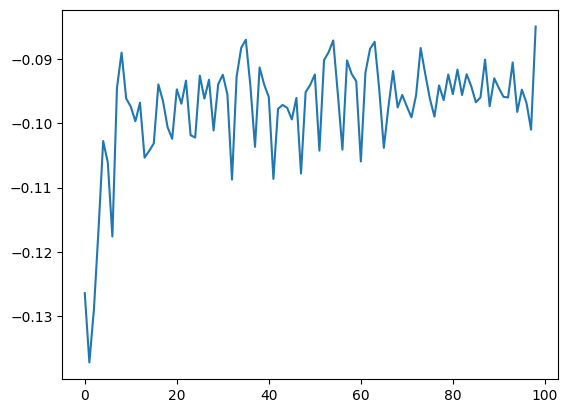

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f['data']['demo_0']['rewards'][:,0])

In [3]:
import h5py
import matplotlib.pyplot as plt

In [4]:
file = h5py.File("test_hdf5_save_0.hdf5", "r")

In [13]:
import imageio
from IPython.display import Video

def generate_video(frames, filename='test_render.mp4'):
    # Create a video writer object
    video_writer = imageio.get_writer(filename, fps=30)

    # Iterate through each frame in the frames list and add it to the video
    for frame in frames:
        video_writer.append_data(frame)

    # Close the video writer to finalize the video file
    video_writer.close()


In [18]:
generate_video(file['data/demo_101/obs/hand_side_inter'][:].astype(np.uint8), 'test_render.mp4')
# Display the video in the Jupyter notebook
Video("test_render.mp4")
